In [ ]:
!pip install u8darts[all] optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime, timedelta

import requests
import darts
import random
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RegressionModel, CatBoostModel, RandomForest, LightGBMModel, XGBModel, RNNModel
from darts.metrics import rmse, mape
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression
import optuna
from pytorch_lightning.callbacks import EarlyStopping


from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
data = pd.read_csv('/kaggle/input/df-final-karachi/df_final_Karachi.csv')
data.tail(10)

,time,city,temperature_2m_min,temperature_2m_mean,temperature_2m_max,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
4956,2023-07-28,Karachi,27.4,28.5,30.2,2.8,13.366667,1.1,8,0.1375,32.4,47.2,16.61,4.00
4957,2023-07-29,Karachi,27.3,28.5,30.3,3.0,13.333333,0.8,8,0.1000,33.9,50.4,18.17,4.23
4958,2023-07-30,Karachi,27.2,28.6,30.3,3.1,13.333333,0.9,9,0.1000,28.4,44.6,15.24,3.60
4959,2023-07-31,Karachi,27.3,28.7,30.5,3.2,13.300000,0.9,9,0.1000,30.2,45.0,16.25,3.78
4960,2023-08-01,Karachi,27.2,28.5,30.4,3.2,13.283333,0.9,9,0.1000,31.3,46.1,14.80,3.51
4961,2023-08-02,Karachi,27.0,28.3,30.3,3.3,13.266667,0.5,5,0.1000,34.6,49.7,15.92,3.76
4962,2023-08-03,Karachi,27.0,28.3,30.0,3.0,13.250000,0.6,6,0.1000,29.2,43.6,16.76,3.97
4963,2023-08-04,Karachi,26.8,28.3,30.2,3.4,13.233333,0.0,0,0.0000,25.6,40.3,16.96,3.89
4964,2023-08-05,Karachi,26.7,28.2,30.0,3.3,13.216667,0.1,1,0.1000,28.3,43.2,16.95,4.07
4965,2023-08-06,Karachi,26.6,27.8,29.4,2.8,13.200000,0.5,5,0.1000,37.8,55.4,14.81,3.84


In [ ]:
data['time'] = pd.to_datetime(data['time'])
data.set_index('time', inplace=True)
data.head()

,city,temperature_2m_min,temperature_2m_mean,temperature_2m_max,temp_range,daylight,precipitation_sum,precipitation_hours,precipitation_rate,windspeed_10m_max,windgusts_10m_max,shortwave_radiation_sum,et0_fao_evapotranspiration
time,,,,,,,,,,,,,
2010-01-01,Karachi,14.8,20.9,26.0,11.2,10.633333,0.0,0,0.0,18.3,25.6,16.25,4.38
2010-01-02,Karachi,15.6,20.5,25.3,9.7,10.616667,0.0,0,0.0,24.6,35.3,9.15,3.84
2010-01-03,Karachi,14.3,19.9,25.0,10.7,10.633333,0.0,0,0.0,16.6,28.1,16.03,3.69
2010-01-04,Karachi,15.0,20.4,25.6,10.6,10.650000,0.0,0,0.0,14.0,22.7,16.32,3.63
2010-01-05,Karachi,16.3,20.7,25.4,9.1,10.650000,0.0,0,0.0,19.3,29.2,16.37,3.55


**NOTE**

I found the best parameters that produce the best results using **Optuna** and then used those parameters for each fearure below

## **et0_fao_evapotranspiration**

**Using best parameters on a new Model**

In [ ]:
%%time
n_params = {'training_length': 13, 'lr': 0.00039982048662377925, 'dropout': 0.28118606540118873, 'input_chunk_length': 6, 'Model': 'GRU', 'batch_size': 48, 'num_loader_workers': 8}
col = 'et0_fao_evapotranspiration'

train = data.loc[:'2023-07-28']
test = data.loc['2023-07-28':]

y_train = TimeSeries.from_series(train[col])
y_test = TimeSeries.from_series(test[col])
scaler = StandardScaler()

transformer = Scaler(scaler)
series_transformed = transformer.fit_transform(y_train)

early_stopper = EarlyStopping("train_loss",min_delta=0.001, patience=10,verbose=False)
callbacks = [early_stopper]

pl_trainer_kwargs = {
    "accelerator": "auto",
    "callbacks": callbacks,
}

model = RNNModel(
    input_chunk_length=n_params['input_chunk_length'],
    model=n_params['Model'],
    hidden_dim=20,
    dropout=n_params['dropout'],
    batch_size=n_params['batch_size'],
    n_epochs=300,
    optimizer_kwargs={"lr": n_params['lr']},
    model_name="Karachi_RNN",
    pl_trainer_kwargs=pl_trainer_kwargs,
    log_tensorboard=True,
    random_state=42,
    training_length=n_params['training_length'],
    force_reset=True,
    save_checkpoints=True
)

model.fit(
    series=series_transformed, verbose=0,
    num_loader_workers=n_params['num_loader_workers']
          )

preds = model.predict(n=len(test), series=series_transformed)
n_preds = transformer.inverse_transform(preds)

val = rmse(y_test, n_preds)
print(f'RMSE: {val}')

Predicting: 0it [00:00, ?it/s]

RMSE: 0.22536520937875312
CPU times: user 21.2 s, sys: 11.4 s, total: 32.6 s
Wall time: 58.2 s


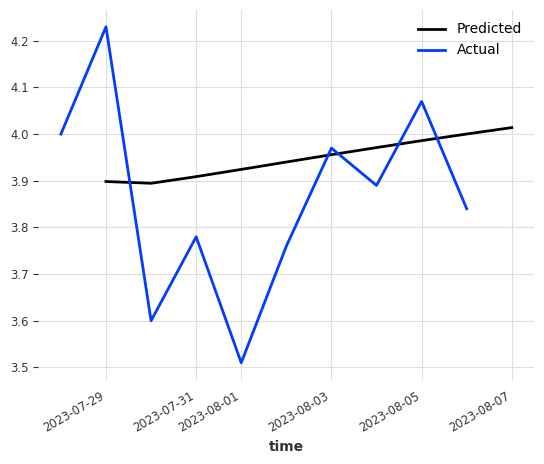

In [ ]:
n_preds.plot(label='Predicted')
y_test.plot(label='Actual')
plt.legend()

## **precipitation_rate**

In [ ]:
%%time
n_params = {'training_length': 23,
 'lr': 0.02017550308521077,
 'dropout': 0.07008706051045033,
 'input_chunk_length': 20,
 'Model': 'LSTM',
 'batch_size': 64,
 'num_loader_workers': 2}

col = 'precipitation_rate'

train = data.loc[:'2023-07-28']
test = data.loc['2023-07-28':]

y_train = TimeSeries.from_series(train[col])
y_test = TimeSeries.from_series(test[col])
scaler = StandardScaler()

transformer = Scaler(scaler)
series_transformed = transformer.fit_transform(y_train)

early_stopper = EarlyStopping("train_loss",min_delta=0.001, patience=10,verbose=False)
callbacks = [early_stopper]

pl_trainer_kwargs = {
    "accelerator": "auto",
    "callbacks": callbacks,
}

model = RNNModel(
    input_chunk_length=n_params['input_chunk_length'],
    model=n_params['Model'],
    hidden_dim=20,
    dropout=n_params['dropout'],
    batch_size=n_params['batch_size'],
    n_epochs=300,
    optimizer_kwargs={"lr": n_params['lr']},
    model_name="Karachi_RNN",
    pl_trainer_kwargs=pl_trainer_kwargs,
    log_tensorboard=True,
    random_state=42,
    training_length=n_params['training_length'],
    force_reset=True,
    save_checkpoints=True
)

model.fit(
    series=series_transformed, verbose=0,
    num_loader_workers=n_params['num_loader_workers']
          )

preds = model.predict(n=len(test), series=series_transformed)
n_preds = transformer.inverse_transform(preds)

val = rmse(y_test, n_preds)
print(f'RMSE: {val}')

Predicting: 0it [00:00, ?it/s]

RMSE: 0.03397997965337979
CPU times: user 7.4 s, sys: 1.68 s, total: 9.08 s
Wall time: 16 s


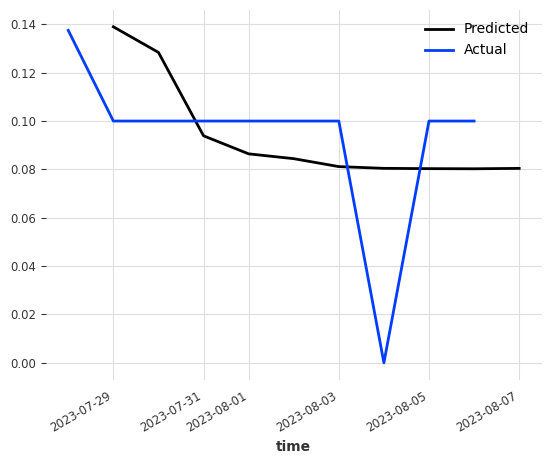

In [ ]:
n_preds.plot(label='Predicted')
y_test.plot(label='Actual')
plt.legend()

## **temperature_2m_max**

In [ ]:
%%time
n_params = {'training_length': 31, 'lr': 1e-3, 'dropout': 0.1070411107413366, 'input_chunk_length': 17, 'Model': 'LSTM', 'batch_size': 16, 'num_loader_workers': 10}
col = 'temperature_2m_max'

train = data.loc[:'2023-07-28']
test = data.loc['2023-07-28':]

y_train = TimeSeries.from_series(train[col])
y_test = TimeSeries.from_series(test[col])
scaler = StandardScaler()

transformer = Scaler(scaler)
series_transformed = transformer.fit_transform(y_train)

early_stopper = EarlyStopping("train_loss",min_delta=0.001, patience=10,verbose=False)
callbacks = [early_stopper]

pl_trainer_kwargs = {
    "accelerator": "auto",
    "callbacks": callbacks,
}

model = RNNModel(
    input_chunk_length=n_params['input_chunk_length'],
    model=n_params['Model'],
    hidden_dim=20,
    dropout=n_params['dropout'],
    batch_size=n_params['batch_size'],
    n_epochs=300,
    optimizer_kwargs={"lr": n_params['lr']},
    model_name="Karachi_RNN",
    pl_trainer_kwargs=pl_trainer_kwargs,
    log_tensorboard=True,
    random_state=42,
    training_length=n_params['training_length'],
    force_reset=True,
    save_checkpoints=True
)

model.fit(
    series=series_transformed, verbose=0,
    num_loader_workers=n_params['num_loader_workers']
          )

preds = model.predict(n=len(test), series=series_transformed)
n_preds = transformer.inverse_transform(preds)

val = rmse(y_test, n_preds)
print(f'RMSE: {val}')

Predicting: 0it [00:00, ?it/s]

RMSE: 0.38326786227031434
CPU times: user 1min 12s, sys: 19.7 s, total: 1min 32s
Wall time: 1min 51s


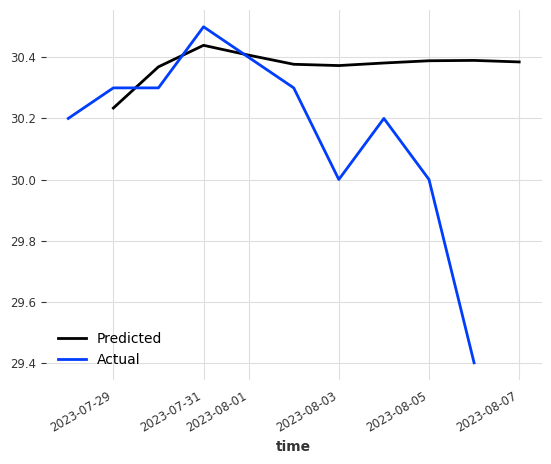

In [ ]:
n_preds.plot(label='Predicted')
y_test.plot(label='Actual')
plt.legend()

# **CONCLUSION**

The models have performed well as they produced good RMSE values. Below is a summary of how the three different features performed in terms of RMSE.

**et0_fao_evapotranspiration** = 0.225

**precipitation_rate** = 0.033

**temperature_2m_max** = 0.383
